# Prediction of Fat Levels in Canadian Cheese

##### <b>Author :</b> Muntakim Rahman &nbsp; <b>UBC Student Number :</b> 71065221

# Introduction

This **Jupyter Notebook** will be implementing *Machine Learning (ML)* models to predict the fat levels in *Canadian* cheeses. 

## Intended Outcome

<b><u>We can utilize a rich understanding of the factors which yield high fat levels to reduce the risk of mass manufacturing an unsuccessful product.</u></b> 

We are already confident that the *Total Addressable Market (TAM)* is particularly concerned with fat level in cheeses (*as per a previous study on consumer tastes*). We would like to manufacture `lower fat` cheese products and this will act as our positive label.

## What is Machine Learning?

*Machine Learning* is defined by *IBM* as *the use of statistical methods, algorithms that are trained to make classifications or predictions, and to uncover key insights in data mining projects. These insights subsequently drive decision making within applications and businesses, ideally impacting key growth metrics.* 

## Cheese Classification

We will be identifying different features within our dataset in order to classify our cheese products as either `lower fat` or `higher fat`.  

### Estimators

We will be training, and evaluating a set of *ML* models (i.e. estimators), which will be compared to a baseline model, in our case a *Dummy Classifier*. 

This will involve : 

<ul>
    <li>Tactful preprocessing of our data with imputation, scaling, feature transformations</li>
    <li>Training the classifier models with an appropriately split and balanced dataset.</li>
    <li>Assessing the model with evaluation metrics.</li>
    <li>Picking the estimator with the best validation score and finetuning the hyperparameters.</li>
</ul>

## Dataset Description

This dataset provides an overview of the different types of Canadian cheeses. The original data was found on the *Government of Canada's Open Government Portal* but has unfortunately been taken down. What we have here is a wrangled and partially cleaned, modified version of the original dataset.

# Exploratory Data Analysis

## Import Packages

In [1]:
import numpy as np
import pandas as pd

import altair as alt

import datetime as dt

from sklearn.model_selection import train_test_split, cross_validate

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer 
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import sklearn.metrics
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from sklearn import set_config

alt.data_transformers.disable_max_rows()

from cheese_functions import *

In [2]:
directory_df = pd.read_csv("data/canadianCheeseDirectory.csv")
display(directory_df.head())

,CheeseId,CheeseNameEn,CheeseNameFr,ManufacturerNameEn,ManufacturerNameFr,ManufacturerProvCode,ManufacturingTypeEn,ManufacturingTypeFr,WebSiteEn,WebSiteFr,...,Organic,CategoryTypeEn,CategoryTypeFr,MilkTypeEn,MilkTypeFr,MilkTreatmentTypeEn,MilkTreatmentTypeFr,RindTypeEn,RindTypeFr,LastUpdateDate
0,228,NaN,Sieur de Duplessis (Le),NaN,Fromages la faim de loup,NB,Farmstead,Fermière,NaN,NaN,...,0,Firm Cheese,Pâte ferme,Ewe,Brebis,Raw Milk,Lait cru,Washed Rind,Croûte lavée,2016-02-03
1,242,NaN,Tomme Le Champ Doré,NaN,Fromages la faim de loup,NB,Farmstead,Fermière,NaN,NaN,...,0,Semi-soft Cheese,Pâte demi-ferme,Cow,Vache,Raw Milk,Lait cru,Washed Rind,Croûte lavée,2016-02-03
2,301,Provolone Sette Fette (Tre-Stelle),Provolone Sette Fette (Tre-Stelle),Tre Stelle (Arla Foods),NaN,ON,Industrial,Industrielle,http://www.trestelle.ca/english/,http://www.trestelle.ca/francais/,...,0,Firm Cheese,Pâte ferme,Cow,Vache,Pasteurized,Pasteurisé,NaN,NaN,2016-02-03
3,303,NaN,Geai Bleu (Le),NaN,Fromages la faim de loup,NB,Farmstead,Fermière,NaN,NaN,...,0,Veined Cheeses,Pâte persillée,Cow,Vache,Raw Milk,Lait cru,NaN,NaN,2016-02-03
4,319,NaN,Gamin (Le),NaN,Fromages la faim de loup,NB,Farmstead,Fermière,NaN,NaN,...,1,Semi-soft Cheese,Pâte demi-ferme,Cow,Vache,Raw Milk,Lait cru,Washed Rind,Croûte lavée,2016-02-03


In [3]:
data_df = pd.read_csv("data/cheese_data.csv")
display(data_df.head())

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


## Split Training and Test Datasets

Let's start by separating our training and test datasets. We're going to be working with a *80%* training and *20%* test set split and set our `random_state` variable to *77*.

### Golden Rule of Machine Learning

We don't want the test data to influence our model **in any way**. This must act as completely unseen data during the model training and validation process.


In [4]:
train_df, test_df = train_test_split(data_df, test_size = 0.2, random_state = 77)

In [5]:
X_train, y_train = train_df.drop(columns = ['FatLevel']), train_df['FatLevel']
X_test, y_test = test_df.drop(columns = ['FatLevel']), test_df['FatLevel']

## Exploratory Data Analysis



### Observe Outputs

Let's start by plotting a bar chart showing the quantity of each `FatLevel` in the training data.

In [6]:
fig_number = 1

fat_prop = alt.Chart(
    train_df,
    title = alt.TitleParams(
        text = f'Figure {fig_number} : Fat Levels for Canadian Cheeses',
        subtitle = '''Data found on the Government of Canada's Open Government Portal''',
        fontSize = 20, subtitleFontSize = 15,
        anchor = 'start'
    )
).transform_joinaggregate(
    total = 'count(*)'
).transform_calculate(
    pct = '1 / datum.total'
).mark_bar().encode(
    x = alt.X('count()', title = 'Quantity'),
    y = alt.Y('FatLevel:N', title = 'Fat Level'),
    tooltip = [alt.Tooltip('sum(pct):Q', format = '.2%', formatType = 'number', title = '% of Total')],
    color = alt.Color(
        'FatLevel:N', 
        scale = alt.Scale(
            domain = ['lower fat', 'higher fat'], 
            range = ['teal', 'crimson']
        ), 
        legend = alt.Legend(title = 'Fat Level')
    )
).properties(
    width = 500, height = 300,
).configure_axis(labelFontSize = 12, titleFontSize = 15)

display(fat_prop)

fig_number += 1


alt.Chart(...)

#### Imbalanced Data

There's a high percentage of `lower fat` cheeses included in the training data, approximately *65.55%* of the dataset. We're going to need to balance the dataset so each of the `FatLevels` above are *50%*.

### Data Sparsity

Let's get an understanding of the data sparsity (i.e. *NULL* values).

In [7]:
display(train_df.describe())

,CheeseId,MoisturePercent,Organic
count,833.000000,823.000000,833.000000
mean,1557.866747,46.955043,0.094838
std,451.129129,9.557279,0.293167
min,228.000000,12.000000,0.000000
25%,1288.000000,40.000000,0.000000
50%,1535.000000,46.000000,0.000000
75%,1902.000000,52.000000,0.000000
max,2390.000000,88.000000,1.000000


In [8]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 110 to 727
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              833 non-null    int64  
 1   ManufacturerProvCode  833 non-null    object 
 2   ManufacturingTypeEn   833 non-null    object 
 3   MoisturePercent       823 non-null    float64
 4   FlavourEn             649 non-null    object 
 5   CharacteristicsEn     514 non-null    object 
 6   Organic               833 non-null    int64  
 7   CategoryTypeEn        814 non-null    object 
 8   MilkTypeEn            832 non-null    object 
 9   MilkTreatmentTypeEn   779 non-null    object 
 10  RindTypeEn            583 non-null    object 
 11  CheeseName            833 non-null    object 
 12  FatLevel              833 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 91.1+ KB


None

It seems that the `FlavourEn`, `CharacteristicsEn`, `RindTypeEn` have a high amount of *NULL* values. Let's visualize the distribution in the dataset.

### Observe Data Sparsity

In [9]:
heatmap_df =  X_train.isna().reset_index()
heatmap_df.rename(columns = {'index' : 'Index'}, inplace = True)
heatmap_df = heatmap_df.melt(
    id_vars = 'Index', 
    value_vars = [col for col in heatmap_df.columns.to_list() if col != 'Index'],
    var_name = 'Columns',
    value_name = 'IsNull'
)

In [10]:
sparsity_plot = alt.Chart(
        heatmap_df,
        title = alt.TitleParams(f'Figure {fig_number} : Cheese Dataset - Data Availability', fontSize = 27.5)
).mark_rect().encode(
    x = alt.X(
        'Index:Q', title = '', axis = None
    ),
    y = alt.Y('Columns:N', title = 'Features'), 
    tooltip = [alt.Tooltip('Index:Q', title = 'Index')],
    color = alt.Color(
        'IsNull:O', 
        scale = alt.Scale(                
            domain = [False, True], 
            range = ['#000000', '#FFFFFF']
        ), 
        legend = alt.Legend(title = 'Null Data')
    ), 
).properties(
    height = 500, width = 600,
).configure_axis(labelFontSize = 15, titleFontSize = 20)

display(sparsity_plot)

fig_number += 1

alt.Chart(...)

### Drop Columns From Dataset

From the visualization above, lets exclude `CharacteristicsEn`, `FlavourEn` due to the high level of data sparsity. Let's remove `RindTypeEn` as well. From displaying `train_df.info()` it seems as if the data sparsity is higher than it appears from Figure 2. 

We should also drop the `CheeseIds` from our training dataset since these won't be useful for statistical modeling.

In [11]:
X_train.drop(
    columns = ['CheeseId', 'CharacteristicsEn', 'FlavourEn', 'RindTypeEn'], 
    inplace = True
)

### Observe Feature Types

Let's distinguish the feature types in our dataset.

In [12]:
describe_df = X_train.describe(include = 'all').T
display(describe_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ManufacturerProvCode,833,10,QC,637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ManufacturingTypeEn,833,3,Industrial,371,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MoisturePercent,823.0,NaN,NaN,NaN,46.955043,9.557279,12.0,40.0,46.0,52.0,88.0
Organic,833.0,NaN,NaN,NaN,0.094838,0.293167,0.0,0.0,0.0,0.0,1.0
CategoryTypeEn,814,6,Firm Cheese,276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MilkTypeEn,832,8,Cow,591,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MilkTreatmentTypeEn,779,3,Pasteurized,640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CheeseName,833,830,Ménestrel (Le),2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
objects_df = X_train.describe(include = 'object').T
display(objects_df)

,count,unique,top,freq
ManufacturerProvCode,833,10,QC,637
ManufacturingTypeEn,833,3,Industrial,371
CategoryTypeEn,814,6,Firm Cheese,276
MilkTypeEn,832,8,Cow,591
MilkTreatmentTypeEn,779,3,Pasteurized,640
CheeseName,833,830,Ménestrel (Le),2


In [14]:
numeric_df = X_train.describe(include = ['int64', 'float64']).T
display(numeric_df)

,count,mean,std,min,25%,50%,75%,max
MoisturePercent,823.0,46.955043,9.557279,12.0,40.0,46.0,52.0,88.0
Organic,833.0,0.094838,0.293167,0.0,0.0,0.0,0.0,1.0


#### Numeric Feature

The `MoisturePercent` column is a numeric feature.

In [15]:
numeric_feats = [feat for feat in numeric_df.index if len(X_train[feat].unique()) != 2]
display(numeric_feats)

['MoisturePercent']

In [16]:
fig_number = describe_features(
    effective_df = X_train, 
    features = numeric_feats, 
    fig_number = fig_number
)

The distinct values in the MoisturePercent column are : 
[52.0, 40.0, 48.0, 55.0, 60.0, 39.0, 50.0, 56.0, 57.0, 46.0, 42.0, 58.0, 37.0, 44.0, 59.0, 88.0, 41.0, 43.0, 33.0, 35.0, 38.0, 27.0, nan, 36.0, 45.0, 61.0, 31.0, 80.0, 68.0, 62.0, 51.0, 64.0, 76.0, 34.0, 74.0, 47.0, 49.0, 29.0, 54.0, 40.3, 32.0, 22.0, 70.0, 86.0, 65.0, 75.0, 26.0, 78.0, 20.0, 23.0, 72.0, 63.0, 49.4, 12.0, 25.0, 53.0, 30.0, 17.0, 47.9, 42.8, 42.6, 83.0, 69.0, 51.7, 21.0]


alt.Chart(...)

#### Binary Feature

The `Organic` column is a binary feature.

In [17]:
binary_feats = [feat for feat in describe_df.index if len(X_train[feat].unique()) == 2]
display(binary_feats)

['Organic']

In [18]:
fig_number = describe_features(
    effective_df = X_train, 
    features = binary_feats, 
    fig_number = fig_number
) 

The distinct values in the Organic column are : 
[0, 1]


alt.Chart(...)

#### Categorical Features

The `ManufacturerProvCode`, `ManufacturingTypeEn`, `CategoryTypeEn`, `MilkTypeEn`, `MilkTreatmentTypeEn` columns are categorical features.

In [19]:
categorical_feats = objects_df[
    (objects_df['unique'] < 0.1 * objects_df['count']) &
    (objects_df['freq'] != 2)     
].index.to_list()

display(categorical_feats)

['ManufacturerProvCode',
 'ManufacturingTypeEn',
 'CategoryTypeEn',
 'MilkTypeEn',
 'MilkTreatmentTypeEn']

In [20]:
fig_number = describe_features(
    effective_df = X_train, features = categorical_feats, 
    fig_number = fig_number, sort_by = 'x'
)

The distinct values in the ManufacturerProvCode column are : 
['ON', 'QC', 'BC', 'AB', 'NB', 'NS', 'PE', 'MB', 'NL', 'SK']


alt.Chart(...)

The distinct values in the ManufacturingTypeEn column are : 
['Industrial', 'Artisan', 'Farmstead']


alt.Chart(...)

The distinct values in the CategoryTypeEn column are : 
['Semi-soft Cheese', 'Firm Cheese', 'Soft Cheese', 'Fresh Cheese', nan, 'Hard Cheese', 'Veined Cheeses']


alt.Chart(...)

The distinct values in the MilkTypeEn column are : 
['Cow', 'Goat', 'Ewe', 'Ewe and Cow', 'Cow and Goat', 'Cow, Goat and Ewe', 'Ewe and Goat', 'Buffalo Cow', nan]


alt.Chart(...)

The distinct values in the MilkTreatmentTypeEn column are : 
['Pasteurized', 'Raw Milk', 'Thermised', nan]


alt.Chart(...)

#### Free-Text Feature

The `CheeseName` column is a free text feature in our dataset. This is going to be fun to tackle. Let's start by printing the values to see what we have to deal with.

In [21]:
text_feats = objects_df[
        (objects_df['unique'] > 0.1 * objects_df['count']) &
        (objects_df['freq'] == 2)     
    ].index.to_list()
display(text_feats)

['CheeseName']

In [22]:
for feat in text_feats : 
    print(f'''The distinct values in the {feat} column are : \n{list(X_train[feat].unique())}\n''')

The distinct values in the CheeseName column are : 
['Vaquinha  (Portuguese)', 'Gorgonzola (Castello)', 'Tête à Papineau', 'Petit Rubis (Le)', 'Petites Soeurs (Les)', 'Cheddar 2 ans (Fromagerie Perron)', 'Brie Normandie double crème', 'Médard (Le)', 'Champfleury (Vaudreuil)', "St.John's Cow (Portuguese)", "Extra chèvre (L')", 'Chevrier', 'Tablée (La)', 'Sieur Riou-x (Le)', 'Médaillon et le Tournevent (Le)', 'Brie Vaudreuil Double Crème', 'Cheddar (Mornington Dairy)', 'Trésor du Fumoir', 'Caprice des Saisons', "P'tit féta", 'Damablanc', "Rayon d'or", "Cheddar L'Autre Versant", 'Menoum!', 'Eweda cru (Best Baa Dairy)', 'Cheddar (Biobio) - 1 year, 2 years and 3 years', 'Cracked Pepper Verdelait', 'Bocconcini (International Cheese)', 'Savoury Moon', 'Petit Poitou (Le)', 'Cheddar Coaticook', 'Légère Brise du Matin', 'Mozzarella (Lino)', 'FRESK-O', 'Evanturel', 'Brie double crème Provençal', 'Santa Lucia Tuma', 'Baluchon', "Alpinois (L')", 'Tomme Ferlend', 'Raclette (Little Qualicum)', 'Brie 

## Preprocessing The Data

### Transformation Pipelines

We're going to transform the feature types with respective transformation pipelines.

### Binary Transformer

To begin, we perform imputation on the binary feature with the `most_frequent` value to replace missing values. Then we use `OneHotEncoder()` to numerically encode each binary value (i.e. *True*, *False*). Note that we only need to keep a single binary column and can drop the other.


In [23]:
binary_transformer = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OneHotEncoder(dtype = int, handle_unknown = 'error', drop = 'if_binary')
)

### Numeric Transformer

We perform imputation on numeric features with the `median` value to replace missing values. Then we will standardize the numeric features to set sample mean to *0* and standard deviation to *1*.

In [24]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy = 'median'),
    StandardScaler()
)

### Categorical Transformer

We perform imputation on categorical features with the `most_frequent` value to replace missing values. Then we use `OneHotEncoder()` to numerically encode each categorical value.

In [25]:
categorical_transformer = make_pipeline(
    SimpleImputer(strategy = 'most_frequent', fill_value = 'missing'),
    OneHotEncoder(dtype = int, handle_unknown = 'ignore')
)

### Free-Text Transformer

We apply the `CountVectorizer()` tool on the free-text feature with the `most_frequent` value and convert the text messages to a matrix of word counts. Each text message is assigned a row and each column represents a word in the dataset vocabulary. The values in the matrix represents the frequency of occurance of the word.

In [26]:
text_transformer = make_pipeline(
    CountVectorizer(binary = True)
)

### Column Transformer

We map the feature types to the transformer pipelines made above and drop the remainder of the dataset columns.

In [27]:
preprocessor = make_column_transformer(
    # Preprocessing Pipelines
    (binary_transformer, binary_feats),
    (numeric_transformer, numeric_feats),
    (categorical_transformer, categorical_feats),
    (text_transformer, text_feats[0]),
    remainder = 'drop'
)

# ML Models

We will be implementing our preprocessor pipelines with multiple classifiers and viewing the results of each model.

We will be training our dataset with the following Classification ML models.

* *Logistic Regression* Classification
* *Decision Tree* Classifier
* *Random Forest* Classifier
* *K Nearest Neighbors (k-NN)* Classifier
* *Support Vector Machines (SVM)* Classifier

This set of classifiers includes 

* Interpretable Modelling (i.e. *Logistic Regression*)
* Rule-Based Algorithms with If-Else Statements (i.e. *Decision Tree*, *Random Forest*)
* Similarity Based Models (i.e. *k-NN*, *SVM*)

In [28]:
models = {
    'Logistic Regression' : {
        'pipeline' : make_pipeline(
            preprocessor, LogisticRegression(random_state = 77, class_weight = 'balanced')
        )
    },
    'Decision Tree' : {
            'pipeline' : make_pipeline(
                preprocessor, DecisionTreeClassifier(random_state = 77, class_weight = 'balanced')
            )
        }, 
    'Random Forest' : 
        {
            'pipeline' : make_pipeline(
                preprocessor, RandomForestClassifier(random_state = 77, class_weight = 'balanced')
            )
        },
    'kNN' : 
        {
            'pipeline' : make_pipeline(
                preprocessor, KNeighborsClassifier()
            )
        },
    'RBF SVC' : 
        {
            'pipeline' : make_pipeline(
                preprocessor, SVC(random_state = 77, class_weight = 'balanced')
            )
        }
}

## Baseline Model

We will be comparing our classifier models to a *DummyClassifier* estimator using *strategy = 'most_frequent'*.

In [29]:
dummy_pipe = make_pipeline(
    preprocessor,
    DummyClassifier(random_state = 77, strategy = 'most_frequent')
)

## Evaluation Metrics

We will be comparing our model performance based on the following metrics : 

* Accuracy 
    * "Percentage of Predictions Which Are True"
* Precision
    * "Percentage of Positive Predictions Which Are True"
* F1 Score
    * Combined Score of : </br>
    &nbsp;&nbsp;&nbsp;&nbsp;"Percentage of Positive Predictions Which Are True"</br> 
    &nbsp;&nbsp;&nbsp;&nbsp;"Percentage of All Positive Examples Which Are Positive Predictions"

### Exclusion of Recall

We have excluded Recall from the Evaluation Metrics due to our interest in making the most out of the investment decisions we take as an organization.

In other words, we want to determine if a particular combination of features will yield a successful cheese product. The combinations we miss are unfortunate, but we want to prioritize the reduction (elimination?) of *False Negative* predictions.


In [30]:
scoring_dict = {    
    'accuracy' : make_scorer(accuracy_score),
    'precision' : make_scorer(precision_score, pos_label = 'lower fat'),
    'f1' : make_scorer(f1_score, pos_label = 'lower fat'),
}

In [31]:
dummy_df = pd.DataFrame(
    cross_validate(
        estimator = dummy_pipe, cv = 10,
        X = X_train, y = y_train,
        scoring = scoring_dict,
        return_train_score = True
    )
).mean().apply(
    lambda x : round(x, 4)
).rename('Dummy Classifier').to_frame().T.reset_index().rename(
    columns = {'index' : 'model'}
)
display(dummy_df)

,model,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_f1,train_f1
0,Dummy Classifier,0.0282,0.0165,0.6555,0.6555,0.6555,0.6555,0.7919,0.7919


In [32]:
scores_df = pd.DataFrame()

for model_name, model in models.items():

    model['scores'] = pd.DataFrame(
        cross_validate(
            estimator = model['pipeline'], cv = 10,
            X = X_train, y = y_train,
            return_train_score = True,
            scoring = scoring_dict
        )
    ).mean().apply(
        lambda x : round(x, 4)
    ).rename(
        model_name
    ).to_frame().T.reset_index().rename(
        columns = {'index' : 'model'}
    )
    
    scores_df = pd.concat([scores_df, model['scores']], axis = 0)  


In [33]:
# We Need to Concatenate the Classifier Scores to the Baseline Model Score.
scores_df = pd.concat([dummy_df, scores_df], axis = 0)
scores_df = scores_df.rename(
    columns = {
        col : col.replace('test', 'validation').replace('time', 'time (s)')  for col in scores_df.columns.to_list()
    }
)
display(scores_df) 

,model,fit_time (s),score_time (s),validation_accuracy,train_accuracy,validation_precision,train_precision,validation_f1,train_f1
0,Dummy Classifier,0.0282,0.0165,0.6555,0.6555,0.6555,0.6555,0.7919,0.7919
0,Logistic Regression,0.0597,0.0142,0.8067,0.9198,0.8685,0.9615,0.8490,0.9373
0,Decision Tree,0.0367,0.0141,0.8139,1.0000,0.8684,1.0000,0.8552,1.0000
0,Random Forest,0.3105,0.0279,0.8366,1.0000,0.8360,1.0000,0.8826,1.0000
0,kNN,0.0283,0.0201,0.7934,0.8609,0.8203,0.8679,0.8473,0.8975
0,RBF SVC,0.0678,0.0176,0.8294,0.9160,0.8809,0.9559,0.8677,0.9344


In [34]:
fig_number = get_scores_chart(
    scores_df = scores_df,
    scoring = 'fit_time',
    fig_number = fig_number
)

,model,score_type,score
0,Dummy Classifier,fit_time (s),0.0282
1,Logistic Regression,fit_time (s),0.0597
2,Decision Tree,fit_time (s),0.0367
3,Random Forest,fit_time (s),0.3105
4,kNN,fit_time (s),0.0283


alt.Chart(...)

We can see from the figure that the *Random Forest* had a much greater fitting time than the other classifiers, whereas the *k-NN* classifier model had the least fitting time. It's worthwhile to note that all of the classifiers had a relatively similar fitting time, aside from the *Random Forest* model.

In [35]:
fig_number = get_scores_chart(
    scores_df = scores_df,
    scoring = 'precision',
    fig_number = fig_number
)

,model,score_type,score
6,Dummy Classifier,train_precision,0.6555
7,Logistic Regression,train_precision,0.9615
8,Decision Tree,train_precision,1.0000
9,Random Forest,train_precision,1.0000
10,kNN,train_precision,0.8679


alt.Chart(...)

We can see in this figure that the best *precision* validation score is from the *RBF SVC* model. We notice that the *Dummy Classifier* model had the lowest *precision* validation score. So far, the *RBF SVC* seems like a promising contender for hyperparameter optimization.

In [36]:
fig_number = get_scores_chart(
    scores_df = scores_df,
    scoring = 'f1',
    fig_number = fig_number
)

,model,score_type,score
6,Dummy Classifier,train_f1,0.7919
7,Logistic Regression,train_f1,0.9373
8,Decision Tree,train_f1,1.0000
9,Random Forest,train_f1,1.0000
10,kNN,train_f1,0.8975


alt.Chart(...)

We can see in this figure that the highest *F1* validation score is from the *Random Forest* model. The second highest *F1* validation score is from the *RBF SVC* model. The *Dummy Classifier* baseline model once again had the lowest *F1* validation score.

Given the high fitting time of the *Random Forest* model and our emphasis on *precision*, we will be selecting the *RBF SVC* model for hyperparameter optimization. 

## RBF SVC Model

### Hyperparameter Optimization 

Let's optimize the `C` and `gamma` hyperparameters in our model. We will find the best hyperparameters with `GridSearchCV`. We're going to iterate through and exhaust the hyperparameter possibilities since we only have `5^2 = 25` combinations.

We would like to be confident with our cheese product `fat level` predictions to a thorough extent. This will require only slightly more computing resources, which we can run in parallel with `n_jobs = -1`.

In [37]:
# Handle Case Where Dataset Doesn't Contain Positive Predictions

import warnings
warnings.filterwarnings('ignore')

In [38]:
param_grid = {
    "svc__C" : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "svc__gamma" : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

svc_search = GridSearchCV(
    estimator = models['RBF SVC']['pipeline'],
    param_grid = param_grid,
    cv = 10, scoring = scoring_dict['precision'],
    return_train_score = True, n_jobs = -1
)

svc_search.fit(X_train, y_train)
display(svc_search)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        dtype=<class 'int'>))]),
                                                                         ['Organic']),
                                                                        ('pipeline-2',
                                                             

In [39]:
svc_df = pd.DataFrame(svc_search.cv_results_)

display(svc_df.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.083696,0.000698,0.017868,0.000607,0.001,0.001,"{'svc__C': 0.001, 'svc__gamma': 0.001}",0.0,0.0,0.0,...,0.0,0.654667,0.654667,0.654667,0.656,0.656,0.656,0.656,0.4588,0.300356
1,0.083724,0.000310,0.017794,0.000271,0.001,0.01,"{'svc__C': 0.001, 'svc__gamma': 0.01}",0.0,0.0,0.0,...,0.0,0.654667,0.654667,0.654667,0.656,0.656,0.656,0.656,0.4588,0.300356
2,0.083724,0.000607,0.017838,0.000267,0.001,0.1,"{'svc__C': 0.001, 'svc__gamma': 0.1}",0.0,0.0,0.0,...,0.0,0.654667,0.654667,0.654667,0.656,0.656,0.656,0.656,0.4588,0.300356
3,0.083231,0.000460,0.017698,0.000167,0.001,1,"{'svc__C': 0.001, 'svc__gamma': 1}",0.0,0.0,0.0,...,0.0,0.654667,0.654667,0.654667,0.656,0.656,0.656,0.656,0.4588,0.300356
4,0.083482,0.000522,0.017761,0.000206,0.001,10,"{'svc__C': 0.001, 'svc__gamma': 10}",0.0,0.0,0.0,...,0.0,0.654667,0.654667,0.654667,0.656,0.656,0.656,0.656,0.4588,0.300356


#### Best Model

In [40]:
best_model = svc_search.best_estimator_

best_svc = svc_search.best_params_
print(f'The best value of C is {best_svc["svc__C"]} and the best value of gamma is {best_svc["svc__gamma"]}.')

best_svc_score = round(svc_search.best_score_, 2)
print(f'The best validation precision is {best_svc_score}.') 

The best value of C is 0.1 and the best value of gamma is 0.01.
The best validation precision is 0.88.


### Score Distribution

Let's look at the score distributions for the different hyperparameter combinations.

In [41]:
svc_plot_df = pd.melt(
    frame = svc_df,
    id_vars = ['param_svc__gamma', 'param_svc__C'],
    var_name = 'score_type', value_name = 'precision', 
    value_vars = ['mean_train_score', 'mean_test_score']
)

display(svc_plot_df)

,param_svc__gamma,param_svc__C,score_type,precision
0,0.001,0.001,mean_train_score,0.458800
1,0.01,0.001,mean_train_score,0.458800
2,0.1,0.001,mean_train_score,0.458800
3,1,0.001,mean_train_score,0.458800
4,10,0.001,mean_train_score,0.458800
...,...,...,...,...
93,0.1,1000,mean_test_score,0.852853
94,1,1000,mean_test_score,0.717279
95,10,1000,mean_test_score,0.657860
96,100,1000,mean_test_score,0.657052


In [42]:
# Create Altair Chart.
svc_plot = alt.Chart(
    svc_plot_df[(svc_plot_df['score_type'] == 'mean_test_score')],
    title = alt.TitleParams(
        text = f'Figure {fig_number} : RBF SVC Model Precision Scores', 
        subtitle = ['Hyperparameter Tuning for C and gamma'],
        anchor = 'start', fontSize = 25, subtitleFontSize = 20
    )
).mark_circle().encode(
    x = alt.X('param_svc__gamma:O', title = 'gamma'),
    y = alt.Y('param_svc__C:O', title = 'C'),
    color = alt.Color(
        'precision:Q', title = 'Precision', 
        scale = alt.Scale(
            scheme = 'viridis', reverse = True,
            domain = [
                svc_plot_df[
                    svc_plot_df['score_type'] == 'mean_test_score'
                ]['precision'].min(), 
                svc_plot_df[
                    svc_plot_df['score_type'] == 'mean_test_score'
                ]['precision'].max()
            ]
        )
    ),
    size = alt.Size(
        'precision:Q', title = 'Precision',
        scale = alt.Scale(
            domain = [
                svc_plot_df[
                    svc_plot_df['score_type'] == 'mean_test_score'
                ]['precision'].min(), 
                svc_plot_df[
                    svc_plot_df['score_type'] == 'mean_test_score'
                ]['precision'].max()
            ]
        )
    ), 
    tooltip = [alt.Tooltip('precision:Q', title = 'Precision')]
).properties(
    width = 800, height = 500,
).configure_axis(
    labelFontSize = 15, titleFontSize = 17.5
).configure_title(
    fontSize = 25
)

fig_number += 1

display(svc_plot)

alt.Chart(...)

## Test Data

Let's start by looking at the evaluation metrics for the best *RBF SVC* classifier.

In [43]:
## We need to drop the columns not used in the Machine Learning pipeline.

X_test.drop(
    columns = ['CheeseId', 'CharacteristicsEn', 'FlavourEn', 'RindTypeEn'], 
    inplace = True
)

In [44]:
svm_fatlevels_report = classification_report(
    y_true = y_test,
    y_pred = svc_search.predict(X_test),
    target_names = ['Lower Fat' if x == 'lower fat' else 'Higher Fat' for x in svc_search.classes_]
)

print(svm_fatlevels_report)

              precision    recall  f1-score   support

  Higher Fat       0.53      0.80      0.64        71
   Lower Fat       0.86      0.64      0.73       138

    accuracy                           0.69       209
   macro avg       0.70      0.72      0.69       209
weighted avg       0.75      0.69      0.70       209



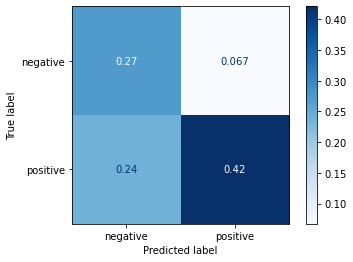

In [45]:
svm_fatlevels_cm = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(
        y_true = y_test, y_pred = best_model.predict(X_test),
        normalize = 'all'
    ), 
    display_labels = ['negative', 'positive']
)

svm_fatlevels_cm.plot(cmap = 'Blues')

We have highly reduced our *False Positive* predictions to *6.7%* with the *RBF SVC* model. This yields a *precision* score of *86%*. 

Note that the *False Negatives* are much higher at *24%* of our predictions. This yields a lower *F1* score of *73%*

In [46]:
baseline_fatlevels_report = classification_report(
    y_true = y_test,
    y_pred = dummy_pipe.fit(X_train, y_train).predict(X_test),
)

print(baseline_fatlevels_report)

              precision    recall  f1-score   support

  higher fat       0.00      0.00      0.00        71
   lower fat       0.66      1.00      0.80       138

    accuracy                           0.66       209
   macro avg       0.33      0.50      0.40       209
weighted avg       0.44      0.66      0.53       209



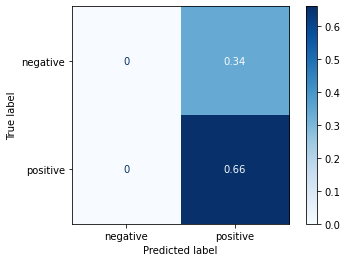

In [47]:
baseline_fatlevels_cm = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(
        y_true = y_test, y_pred = dummy_pipe.fit(X_train, y_train).predict(X_test),
        normalize = 'all'
    ), 
    display_labels = ['negative', 'positive']
)

baseline_fatlevels_cm.plot(cmap = 'Blues')

The *Dummy Classifier* baseline model was unable to make negative predictions. This is rather peculiar and yields a lower *precision* score of *66%*. Interestingly, the perfect *recall* score yields a higher *F1* score of *80%*.

# Discussion

From this investigation, we were able to observe features which contribute to different fat levels in *Canadian* cheeses and use this in training a Machine Learning classifier to predict whether a cheese will be `lower fat` or `higher fat`. 

## Further Improvements

In order to improve the model performance, something which can be explored is the inclusion of the `CharacteristicsEn` and `FlavourEn` columns. These can be transformed with `CountVectorizer()` and we can see how the data sparsity in these columns affects the training and validation scores. 

In addition to this, we can look at the `RindTypeEn` column and investigate the feature type and value distributions. There was some peculiar data sparsity here, which was apparent from displaying `train_df.info()`, however filtering the dataframe for *NULL* values didn't register the same data. Exploring this feature may be highly valuable for improving model performance across evaluation metrics. 

## Concluding Remarks

We were able to train a *RBF SVC* classifier which performed with *86%* precision. This will aid us in our larger goal of reducing the risk of mass manufacturing unsuccessful cheese products. Since we are predicting a low percentage of *False Negatives* at *6.7%*, we are able to be more confident with the bets that we make. It will be highly beneficial to deploy this model in evaluating test cheese products. If we provide this as a tool to manufacturing experts with extensive domain knowledge, we'll be able to develop a streamlined cheese production practice.

## Citations

These resources provide the theory and code segments for the *ML* exploration in this notebook.

* [IBM - What is Machine Learning?](https://www.ibm.com/topics/machine-learning)
* [Introduction to Machine Learning](https://ml-learn.mds.ubc.ca/)
    * [Assignment 5](../assignment5/assignment5.ipynb)
    * [Assignment 6](../assignment6/assignment6.ipynb)
    * [Assignment 7](../assignment7/assignment7.ipynb)
    * [Assignment 8](../assignment8/assignment8.ipynb)